# **Lab 4 : Israel Elections Data Analysis**
### **ID1:206094278,ID2:205926660** 


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sp

In [2]:
# Read the DF
df_ballots = pd.read_csv("votes per ballot 2020.csv", encoding = 'iso-8859-8', index_col='שם ישוב')
df_ballots = df_ballots.loc[:,["בזב","כשרים", "אמת", "ג", "ודעם",
                             "טב", "ל", "מחל","פה","שס"]]
df_ballots = df_ballots.drop('מעטפות חיצוניות')

df_tilda = pd.DataFrame.copy(df_ballots) # camputing n_ij tilda
for r in range(len(df_tilda)):
    ratio = df_tilda.iloc[r,0] / df_tilda.iloc[r,1] 
    for c in range(2,len(df_tilda.columns)):
        df_tilda.iloc[r,c] = int(df_tilda.iloc[r,c] * ratio)

df_votes = df_tilda.iloc[:,2:]

#### שאלה 1
כתבו פונקציה שעושה תיקון לתוצאות הבחירות ואמידת השכיחויות qj באוכלוסיה של כל מפלגה על ידי
פתרון בעיית הרגרסיה הלינארית הבאה על פי שיטת הריבועים הפחותים. 

In [3]:
# a function that compute a lm for nij and gives q hat
def u_esti(n_ij,n_ij_tilda):
    model = sp.OLS(n_ij_tilda,n_ij).fit() # solving OLS
    param = model.params
    q_hat = n_ij.mul(param).sum().div( n_ij.mul(param).sum().sum()) # compute q hat
    return(q_hat)

#### שאלה 2
כעת חזרו על הסימולציות בשאלה 2 ממעבדה 3 .חשבו את האומדנים qj לכל אחת מ-3 הדרכים
לבחירת vij על פי התיקון בשאלה 1
עבור כל אחת מ-3 דרכי הסימולציה ועבור כל מפלגה הוסיפו ל-plot-bar משאלה 4.2 במעבדה
הקודמת עמודה חדשה עבור התיקון החדש (ממוצע +/- סטיית תקן) והציגו את ה-plots-bar החדשים
(כלומר לכל מפלגה יהיו 4 עמודות). מה מסקנותיכם? באיזה תיקון כדאי להשתמש ומתי?




In [4]:
bazab = df_ballots.loc[:,'בזב']
# the simulations from lab 3 transferd to lab4

# the simulation function
def simu_new(df,v):
    df_simu = pd.DataFrame.copy(df)
    df_m = df.to_numpy() # create a mtrix of nij
    v_m = v.to_numpy() # create a matrix of vij
    before = np.random.binomial(df_m.astype(int),v_m.astype(float))
    after = pd.DataFrame(data=before, columns=df.columns,index= df.index)
    return after

# all the corrections for Vij
def vi_is_vij(df):
    new_df = pd.DataFrame.copy(df)
    for i in range(len(new_df)):
        ratio = new_df.iloc[i,1] / new_df.iloc[i,0]
        new_df.iloc[i,2:] = ratio
    return new_df

df_vi = vi_is_vij(df_ballots)
df_vi = df_vi.iloc[:,2:] 

# creating the vij =uj
df_u_j = pd.DataFrame.copy(df_ballots).iloc[:,2:]
pro = [0.3,0.4,0.7,0.2,0.5,0.9,0.8,0.6]
for i in range(len(pro)):
    df_u_j.iloc[:,i] = df_u_j.iloc[:,i]*0 + pro[i]

# creating the vij=uj randomly    
df_u_jstar = pd.DataFrame.copy(df_ballots).iloc[:,2:]
for i in pd.unique(df_u_jstar.index):
    ran = np.random.choice([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],size=8,replace =False)
    df_u_jstar.loc[i] =  df_u_jstar.loc[i]*0 + ran

In [5]:
# creating 50 simulatins of all the options for vij with the new and old corrections.
ratio = df_ballots.loc[:,'בזב']/df_ballots.loc[:,'כשרים']
simAnew=[]
simA=[]
simAno =[]
# 50 simulation of A  
# where sinBno in the simulation without correction
for i in range(50):
    t = simu_new(df_votes, df_vi)
    simAno.append(t) # no correction
    t1 = round(t.mul(ratio,axis=0))
    simA.append(t1) # correction from lab 3
    t = u_esti(t,bazab)
    simAnew.append(t) # new correction
# 50 simulation of B  
# where sinBno in the simulation without correction
simBnew=[]
simB = []
simBno =[]
for i in range(50):
    t = simu_new(df_votes, df_u_j)
    t1 = round(t.mul(ratio,axis=0))
    simB.append(t1)  # correction from lab 3
    simBno.append(t) # no correction
    t = u_esti(t,bazab)
    simBnew.append(t) # new correction
# 50 simulation of C
# where sinCno in the simulation without correction
simCnew=[]
simC = []
simCno =[]
for j in range(50):
    t=simu_new(df_votes,df_u_jstar) 
    simCno.append(t)  # no correction
    t1 = round(t.mul(ratio,axis=0))
    simC.append(t1) # correction from lab 3
    t = u_esti(t,bazab)
    simCnew.append(t) # new correction

In [6]:
# creating q
q = df_ballots.loc[:,["אמת", "ג", "ודעם",
                             "טב", "ל", "מחל","פה","שס"]]
q= q.sum().div(q.sum().sum())

bazab2=df_ballots.loc[:,'בזב'].sum()

# turnnig each simulatin in to a vector of voteing rate for each party
for i in range(50):
    simA[i] = simA[i].sum().div(bazab2)
    simB[i] = simB[i].sum().div(bazab2)
    simC[i] = simC[i].sum().div(bazab2)
    simAno[i]= simAno[i].sum().div(simAno[i].sum().sum())
    simBno[i]= simBno[i].sum().div(simBno[i].sum().sum())
    simCno[i]= simCno[i].sum().div(simCno[i].sum().sum())
    
# Mean for each simulation
A_mean=pd.DataFrame(simA).sum(axis=0)/50
A_mean_new = pd.DataFrame(simAnew).sum(axis=0)/50
B_mean=pd.DataFrame(simB).sum(axis=0)/50
B_mean_new = pd.DataFrame(simBnew).sum(axis=0)/50
C_mean=pd.DataFrame(simC).sum(axis=0)/50
C_mean_new = pd.DataFrame(simCnew).sum(axis=0)/50
Ano_mean=pd.DataFrame(simAno).sum(axis=0)/50
Bno_mean=pd.DataFrame(simBno).sum(axis=0)/50
Cno_mean=pd.DataFrame(simCno).sum(axis=0)/50

# compute the sd for all the simulations
Ano_sd= np.std(pd.DataFrame(simAno))
A_sd=np.std(pd.DataFrame(simA))
A_new_sd = np.std(pd.DataFrame(simAnew))
Bno_sd= np.std(pd.DataFrame(simBno))
B_sd=np.std(pd.DataFrame(simB))
B_new_sd = np.std(pd.DataFrame(simBnew))
Cno_sd= np.std(pd.DataFrame(simCno))
C_sd= np.std(pd.DataFrame(simC))
C_new_sd = np.std(pd.DataFrame(simCnew))

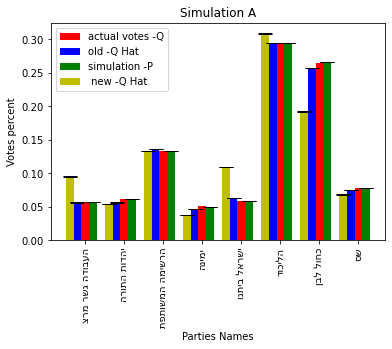

In [7]:
dict_party = {'מחל':'הליכוד','פה':'כחול לבן','ודעם':'הרשימה המשותפת','שס':'שס','ג':'יהדות התורה','אמת':'העבודה גשר מרצ','ל':'ישראל ביתנו','טב':'ימינה'}
names = ["אמת", "ג", "ודעם","טב", "ל", "מחל","פה","שס"]
rev_names = [dict_party[name][::-1] for name in list(names)]
# plot for the first simulatiom Vij=Vi
width = 0.2
width2 =0.4
x_pos = np.arange(8)
fig, ax = plt.subplots()

q_bar=ax.bar(x_pos,q, align='center', capsize=7,width=0.2,color='r')
A_bar=ax.bar(x_pos - width ,A_mean,yerr=A_sd, align='center', capsize=7,width=0.2,color='b')
A_new=ax.bar(x_pos - width2,A_mean_new,yerr=A_new_sd, align='center', capsize=7,width=0.2,color="y")
Ano_bar=ax.bar(x_pos + width,Ano_mean,yerr=Ano_sd, align='center', capsize=7,width=0.2,color='g')
ax.set_xticks(x_pos)
ax.set_title('Simulation A')
ax.set_ylabel('Votes percent')
ax.set_xlabel('Parties Names')
ax.set_xticklabels(rev_names,rotation=90)
ax.legend((q_bar[0], A_bar[0],Ano_bar[0],A_new[0]), ("actual votes -Q",'old -Q Hat','simulation -P',' new -Q Hat'))

plt.show()


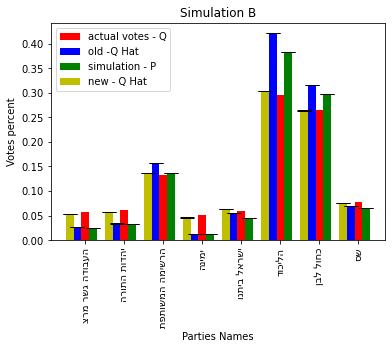

In [8]:
# plot for the second simulation (B)
width = 0.2 
x_pos = np.arange(8)
fig, ax = plt.subplots()

q_bar=ax.bar(x_pos,q, align='center', capsize=5,width=0.2,color='r')
B_bar=ax.bar(x_pos - width ,B_mean, yerr=B_sd, align='center', ecolor='black', capsize=7,width=0.2,color='b')
B_new=ax.bar(x_pos - width2,B_mean_new,yerr=B_new_sd, align='center', capsize=7,width=0.2,color="y")
Bno_bar=ax.bar(x_pos+width,Bno_mean, yerr=Bno_sd, align='center', ecolor='black',width=0.2,capsize=7,color='g')
ax.set_xticks(x_pos)
ax.set_title('Simulation B')
ax.set_ylabel('Votes percent')
ax.set_xlabel('Parties Names')
ax.set_xticklabels(rev_names,rotation=90)
ax.legend((q_bar[0], B_bar[0],Bno_bar[0],B_new[0]), ("actual votes - Q",'old -Q Hat','simulation - P','new - Q Hat'))
plt.show()

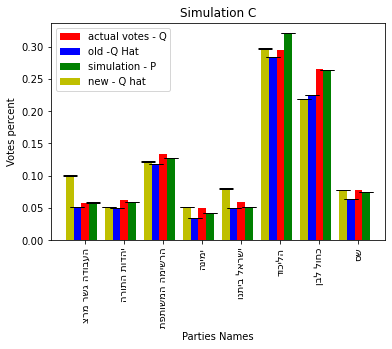

In [9]:
# plot for the third simulation(C)
width = 0.2
x_pos = np.arange(8)
fig, ax = plt.subplots()

q_bar=ax.bar(x_pos,q, align='center', capsize=5,width=0.2,color='r')
C_bar=ax.bar(x_pos-width ,C_mean, yerr=C_sd, align='center', ecolor='black', capsize=7,width=0.2,color='b')
Cno_bar=ax.bar(x_pos + width,Cno_mean, yerr=Cno_sd, align='center', ecolor='black', capsize=7,width=0.2,color='g')
C_new=ax.bar(x_pos - width2,C_mean_new,yerr=C_new_sd, align='center', capsize=7,width=0.2,color="y")
ax.set_xticks(x_pos)
ax.set_title('Simulation C')
ax.set_ylabel('Votes percent')
ax.set_xlabel('Parties Names')
ax.set_xticklabels(rev_names,rotation=90)
ax.legend((q_bar[0], C_bar[0],Cno_bar[0],C_new[0]), ("actual votes - Q",'old -Q Hat','simulation - P','new - Q hat'))
plt.show()


#### תשובה לשאלה 2
עבור ההנחה של $V_{ij} = U_{j}$ רנדומלי נראה שעדיף לעשות את התיקון של ה"ניפוח" של מספר הקולות הכשרים לבזב 
עבור ההנחה $V_{ij} = U_{j}$ התיקון הטוב ביותר להנחה זו הינו התיקון החדש המתבסס על OLS שכן הוא נתון את התוצאות הקרובות ביותר לבחירות האמתיות(כנראה נובע ממשקול נכון של ההסתברות של מצביע ממפלגה j להגיע לקלפי)<br> 
עבור ההנחה שבה $V_{ij} = V_{i}$ רצוי להשתמש בתיקון שהוצג במעבדה 3 ובוא מבצעים "ניפוח" של הנתונים לפי סהכ בעלי זכות הבחירה עם נרמול סהכ של הקולות הכשרים

#### שאלה 3
קראו את הנתונים מקובץ הדירוג החברתי הכלכלי csv.calcali_hevrati_eshkol או
xlsx.calcali_hevrati_eshkol והצליבו אותם עם נתוני הבחירות על פי ישובים ליצירת frame-data
משותף. 
חשבו את תוצאות הבחירות (שכיחות
הקולות pj לכל מפלגה מתוך כלל הקולות הכשרים עבור 8 המפלגות הגדולות) רק בישובים אלו והציגו
אותן מול התוצאות הכלל ארציות בבר עמודות כפול. האם יש הבדלים משמעותיים בין התוצאות הארציות
לתוצאות בישובים שקיבלתם?



Index(['אבו גווייעד שבט', 'אבו גוש', 'אבו סנאן', 'אבו עבדון שבט',
       'אבו קורינאת שבט', 'אבו קרינאת יישוב', 'אבו רובייעה שבט',
       'אבו רוקייק שבט', 'אבו תלול', 'אבטין',
       ...
       'תלמים', 'תמרת', 'תנובות', 'תעוז', 'תפרח', 'תקומה', 'תקוע',
       'תראבין אצאנע שבט', 'תראבין אצאנעישוב', 'תרום'],
      dtype='object', name='שם ישוב', length=1214)

0        אבו גוש
1       אבו סנאן
2          אבטין
3        אבטליון
4          אביאל
          ...   
1023        תעוז
1024        תפרח
1025       תקומה
1026        תקוע
1027        תרום
Name: שם ישוב, Length: 1028, dtype: object

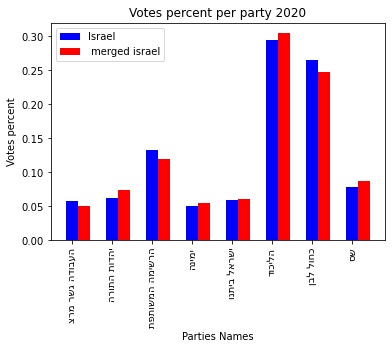

In [10]:
# raad the DF
social_rate =pd.read_excel('eshkol_hevrati_calcali.xlsx', encoding = 'iso-8859-8')

votes_per_city  = pd.read_csv("votes per city 2020.csv", encoding = 'iso-8859-8', index_col='שם ישוב')
votes_per_city = votes_per_city.loc[:,["בזב","כשרים", "אמת", "ג", "ודעם",
                             "טב", "ל", "מחל","פה","שס"]]


df_votes = df_votes.iloc[:,2:]


social_rate.rename(columns={'name':'שם ישוב'}, inplace=True)

merged = pd.merge(votes_per_city,social_rate ,how='inner', on='שם ישוב') # mergeing the two data frames

df_votes = merged.iloc[:, 0:11]
display(votes_per_city.index)
display(df_votes.iloc[:,0])

# creating the plot of the voting rate in both plots
p = df_ballots.iloc[:,2:].sum().div(df_ballots.iloc[:,2:].sum().sum())
p_merge = df_votes.iloc[:,3:].sum().div(df_votes.iloc[:,3:].sum().sum())

fig, ax = plt.subplots()  

all_bar = ax.bar(x_pos, list(p), 0.3, color='b')
merge_bar = ax.bar(x_pos+0.3, list(p_merge), 0.3, color='r')

ax.set_ylabel('Votes percent')
ax.set_xlabel('Parties Names')
ax.set_title('Votes percent per party 2020')
ax.set_xticks(x_pos)
ax.set_xticklabels(rev_names,rotation = 90)
ax.legend((all_bar[0], merge_bar[0]), ('Israel', ' merged israel'))
plt.show()



#### תשובה לשאלה 3
תוצאות הבחירות מאיחוד הטבלאות יוצאות דומות יחסית לתוצאות האמת
אמנם ישנם הבדלים בכל המפלגות בין אחוזי ההצבעה אך סדר הגודל של המפלגות(מבחינת מפת המנדטים) נשמר.
כמו כן, מאיחוד הטבלאות קיבלנו רשימה של 1028 יישובים מתוך 1214 (בערך 85% מכלל הישובים)



#### שאלה 4

סעיף א) הציגו את תוצאות הבחירות שהיו מתקבלות בכל אחד מעשרת הדירוגים החברתיים כלכליים מ-1 עד
10

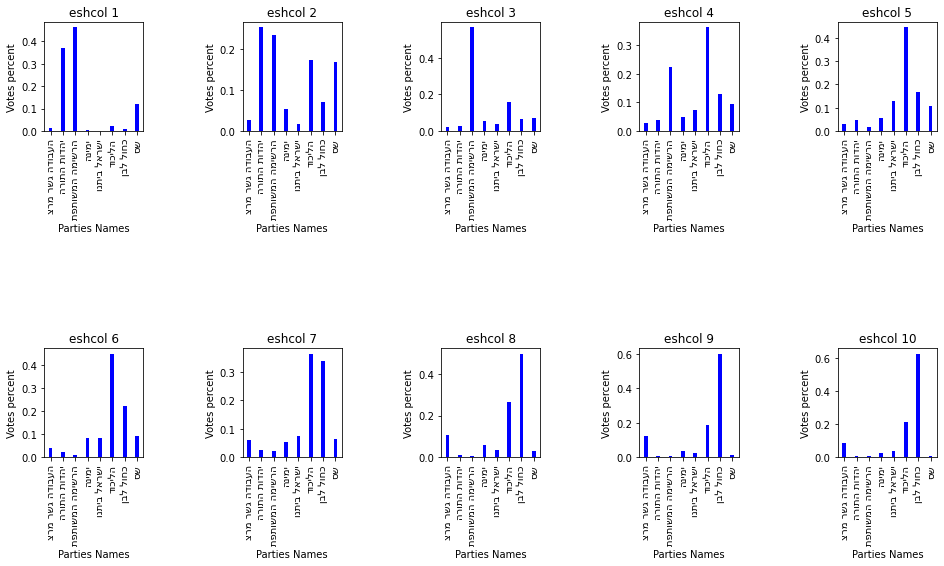

In [11]:
tt=[]
# creating 10 lists for each eshcol voting distribution
for i in range(1,11,1):
    p=merged[merged.eco_level ==i].iloc[:,3:11].sum().div(merged[merged.eco_level ==i].iloc[:,3:11].sum().sum())
    tt.append(p)

# joint plot for all 10 eshcols    
fig,ax = plt.subplots(2,5,figsize=(16,8))
plt.subplots_adjust(hspace =2,wspace =1)
ax[0,0].bar(x_pos,tt[0], 0.3, color='b')
ax[0,0].set_ylabel('Votes percent')
ax[0,0].set_xlabel('Parties Names')
ax[0,0].set_title('eshcol 1')
ax[0,0].set_xticks(x_pos)
ax[0,0].set_xticklabels(rev_names,rotation = 90)
ax[0,1].bar(x_pos,tt[1] , 0.3, color='b')
ax[0,1].set_ylabel('Votes percent')
ax[0,1].set_xlabel('Parties Names')
ax[0,1].set_title('eshcol 2')
ax[0,1].set_xticks(x_pos)
ax[0,1].set_xticklabels(rev_names,rotation = 90)
ax[0,2].bar(x_pos,tt[2] , 0.3, color='b')
ax[0,2].set_ylabel('Votes percent')
ax[0,2].set_xlabel('Parties Names')
ax[0,2].set_title('eshcol 3')
ax[0,2].set_xticks(x_pos)
ax[0,2].set_xticklabels(rev_names,rotation = 90)
ax[0,3].bar(x_pos,tt[3], 0.3, color='b')
ax[0,3].set_ylabel('Votes percent')
ax[0,3].set_xlabel('Parties Names')
ax[0,3].set_title('eshcol 4')
ax[0,3].set_xticks(x_pos)
ax[0,3].set_xticklabels(rev_names,rotation = 90)
ax[0,4].bar(x_pos,tt[4], 0.3, color='b')
ax[0,4].set_ylabel('Votes percent')
ax[0,4].set_xlabel('Parties Names')
ax[0,4].set_title('eshcol 5')
ax[0,4].set_xticks(x_pos)
ax[0,4].set_xticklabels(rev_names,rotation = 90)
ax[1,0].bar(x_pos,tt[5] , 0.3, color='b')
ax[1,0].set_ylabel('Votes percent')
ax[1,0].set_xlabel('Parties Names')
ax[1,0].set_title('eshcol 6')
ax[1,0].set_xticks(x_pos)
ax[1,0].set_xticklabels(rev_names,rotation = 90)
ax[1,1].bar(x_pos,tt[6], 0.3, color='b')
ax[1,1].set_ylabel('Votes percent')
ax[1,1].set_xlabel('Parties Names')
ax[1,1].set_title('eshcol 7')
ax[1,1].set_xticks(x_pos)
ax[1,1].set_xticklabels(rev_names,rotation = 90)
ax[1,2].bar(x_pos,tt[7] , 0.3, color='b')
ax[1,2].set_ylabel('Votes percent')
ax[1,2].set_xlabel('Parties Names')
ax[1,2].set_title('eshcol 8')
ax[1,2].set_xticks(x_pos)
ax[1,2].set_xticklabels(rev_names,rotation = 90)
ax[1,3].bar(x_pos,tt[8] , 0.3, color='b')
ax[1,3].set_ylabel('Votes percent')
ax[1,3].set_xlabel('Parties Names')
ax[1,3].set_title('eshcol 9')
ax[1,3].set_xticks(x_pos)
ax[1,3].set_xticklabels(rev_names,rotation = 90)
ax[1,4].bar(x_pos,tt[9] , 0.3, color='b')
ax[1,4].set_ylabel('Votes percent')
ax[1,4].set_xlabel('Parties Names')
ax[1,4].set_title('eshcol 10')
ax[1,4].set_xticks(x_pos)
ax[1,4].set_xticklabels(rev_names,rotation = 90)
plt.show()

סעיף ב) עבור כל מפלגה, צרו גרף עמודות בו מתואר שכיחות הקולות של המפלגה בישובים ב-10 האשכולות, 
מסודרים.

In [15]:
# a function that calculate the voting rate for each party by economic eshcol
def party_rock(df):
    eshcol=[]    
    for i in range(3,11,1):    
        party=df.iloc[:,[i,14]]
        p=[party[party.eco_level ==j].iloc[:,0].sum()/df_ballots.loc[:,'בזב'].sum() for j in range(1,11,1)]
        eshcol.append(p)
    return(eshcol)


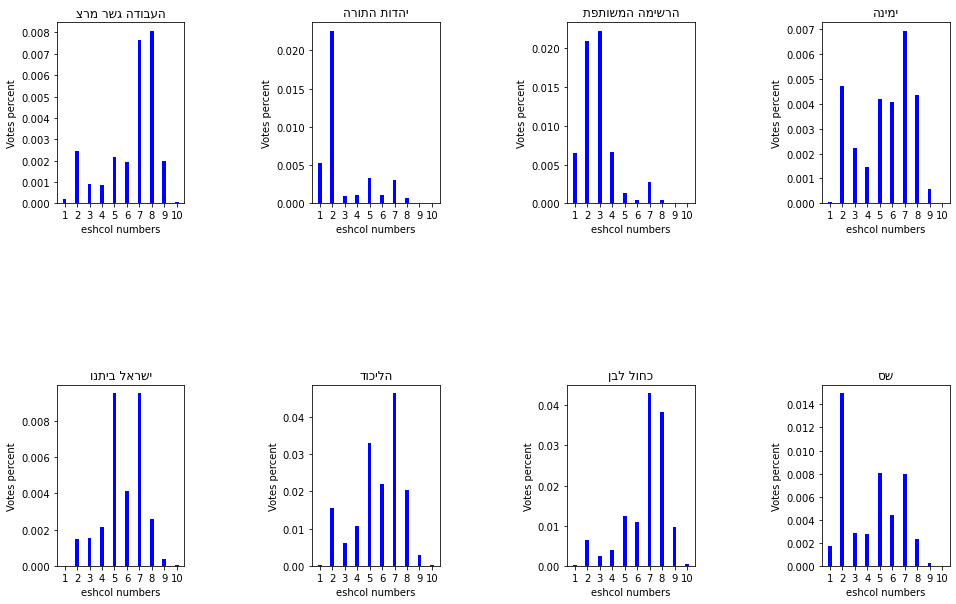

In [16]:
pt=party_rock(merged)
# joint plot for all parties 
x_pos2 = np.arange(10)
fig,ax = plt.subplots(2,4,figsize=(16,10))
plt.subplots_adjust(hspace =1,wspace =1)
ax[0,0].bar(x_pos2,pt[0], 0.3, color='b')
ax[0,0].set_ylabel('Votes percent')
ax[0,0].set_xlabel('eshcol numbers')
ax[0,0].set_title(rev_names[0])
ax[0,0].set_xticks(x_pos2)
ax[0,0].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[0,1].bar(x_pos2,pt[1] , 0.3, color='b')
ax[0,1].set_ylabel('Votes percent')
ax[0,1].set_xlabel('eshcol numbers')
ax[0,1].set_title(rev_names[1])
ax[0,1].set_xticks(x_pos2)
ax[0,1].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[0,2].bar(x_pos2,pt[2] , 0.3, color='b')
ax[0,2].set_ylabel('Votes percent')
ax[0,2].set_xlabel('eshcol numbers')
ax[0,2].set_title(rev_names[2])
ax[0,2].set_xticks(x_pos2)
ax[0,2].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[0,3].bar(x_pos2,pt[3], 0.3, color='b')
ax[0,3].set_ylabel('Votes percent')
ax[0,3].set_xlabel('eshcol numbers')
ax[0,3].set_title(rev_names[3])
ax[0,3].set_xticks(x_pos2)
ax[0,3].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[1,0].bar(x_pos2,pt[4], 0.3, color='b')
ax[1,0].set_ylabel('Votes percent')
ax[1,0].set_xlabel('eshcol numbers')
ax[1,0].set_title(rev_names[4])
ax[1,0].set_xticks(x_pos2)
ax[1,0].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[1,1].bar(x_pos2,pt[5] , 0.3, color='b')
ax[1,1].set_ylabel('Votes percent')
ax[1,1].set_xlabel('eshcol numbers')
ax[1,1].set_title(rev_names[5])
ax[1,1].set_xticks(x_pos2)
ax[1,1].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[1,2].bar(x_pos2,pt[6], 0.3, color='b')
ax[1,2].set_ylabel('Votes percent')
ax[1,2].set_xlabel('eshcol numbers')
ax[1,2].set_title(rev_names[6])
ax[1,2].set_xticks(x_pos2)
ax[1,2].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
ax[1,3].bar(x_pos2,pt[7] , 0.3, color='b')
ax[1,3].set_ylabel('Votes percent')
ax[1,3].set_xlabel('eshcol numbers')
ax[1,3].set_title(rev_names[7])
ax[1,3].set_xticks(x_pos2)
ax[1,3].set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])
plt.show()


In [14]:
merged[merged.eco_level ==3].iloc[:,3]

0        75
1        92
27      243
54        1
55       26
       ... 
971       1
977       0
985       4
993     247
1020      2
Name: אמת, Length: 70, dtype: int64